### Business Recommendations Based on Query EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### 5 Most Popular Commuter Trips
#### Define Commuter:
- Weekday Only
- Morning Commute: 6-9am
- Evening Commute: 3-7pm

  * Answer:
        +----------+-----------------------------------------------+-----------------------------------------------+
        | le_count |              start_station_name               |               end_station_name                |
        +----------+-----------------------------------------------+-----------------------------------------------+
        |   6034   | 2nd at Townsend                               | Harry Bridges Plaza (Ferry Building)          |
        |   6021   | San Francisco Caltrain 2 (330 Townsend)       | Townsend at 7th                               |
        |   5659   | Embarcadero at Folsom                         | San Francisco Caltrain (Townsend at 4th)      |
        |   5608   | Harry Bridges Plaza (Ferry Building)          | 2nd at Townsend                               |
        |   5458   | Embarcadero at Sansome                        | Steuart at Market                             |
        +----------+-----------------------------------------------+-----------------------------------------------+
        
#### Justification:
- After an initial query into most popular travel times as well as standard work day times, it was decided to make the leaving time a larger window than the arrival time as the trends showed commuters had a wider range of hours remaining at work.
- Our query was filtered by weekdays and the specified time above. It was then grouped by station name and then sorted by count.
- The code used is listed below.


In [3]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*), start_station_name, end_station_name, FROM ( SELECT start_date,start_station_name, end_station_name, EXTRACT(DAYOFWEEK FROM start_date) AS dow_int, CASE EXTRACT(DAYOFWEEK FROM start_date) WHEN 1 THEN "Sunday" WHEN 2 THEN "Monday" WHEN 3 THEN "Tuesday" WHEN 4 THEN "Wednesday" WHEN 5 THEN "Thursday" WHEN 6 THEN "Friday" WHEN 7 THEN "Saturday" END AS dow_str, CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend" ELSE "Weekday" END AS dow_weekday, CASE WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 9 THEN "Morning Commute" WHEN EXTRACT(HOUR FROM start_date) >= 15 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Evening Commute" ELSE "Not" END AS commute FROM `bigquery-public-data.san_francisco.bikeshare_trips`) WHERE dow_weekday = "Weekday" and (commute = "Morning Commute" or commute = "Evening Commute") GROUP BY start_station_name, end_station_name ORDER BY 1 DESC LIMIT 5'

Waiting on bqjob_r1650eb8347bb8dc9_000001779d8b2e2b_1 ... (0s) Current status: DONE   
+------+-----------------------------------------+------------------------------------------+
| f0_  |           start_station_name            |             end_station_name             |
+------+-----------------------------------------+------------------------------------------+
| 6034 | 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building)     |
| 6021 | San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                          |
| 5659 | Embarcadero at Folsom                   | San Francisco Caltrain (Townsend at 4th) |
| 5608 | Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                          |
| 5458 | Embarcadero at Sansome                  | Steuart at Market                        |
+------+-----------------------------------------+------------------------------------------+


In [4]:
### Analysis for Recommendations

In [5]:
##Query to csv Minute Breakouts
! bq query --use_legacy_sql=FALSE --format=csv ' SELECT dur_min_str, COUNT(*) AS `le_count` FROM (SELECT duration_sec, CASE WHEN duration_sec < 300 THEN "<5" WHEN duration_sec >= 300 and duration_sec < 600 THEN "5-10" WHEN duration_sec >= 600 and duration_sec < 900 THEN "10-15" WHEN duration_sec >= 900 and duration_sec < 1200 THEN "15-20" WHEN duration_sec >= 1200 and duration_sec < 1500 THEN "20-25" WHEN duration_sec >= 1500 and duration_sec < 1800 THEN "25-30" WHEN duration_sec >= 1800 and duration_sec < 2100 THEN "30-35" WHEN duration_sec >= 2100 and duration_sec < 2400 THEN "35-40" WHEN duration_sec >= 2400 and duration_sec < 2700 THEN "40-45" WHEN duration_sec >= 2700 and duration_sec < 3600 THEN "45-60" WHEN duration_sec >= 3600 THEN "60+" END AS dur_min_str FROM bigquery-public-data.san_francisco.bikeshare_trips) GROUP BY dur_min_str ORDER BY le_count DESC' > min_trip.csv

Waiting on bqjob_r616d1be39c288cd0_000001779d8b3689_1 ... (0s) Current status: DONE   


,Duration Break,Count
0,5-10,415936
1,10-15,231099
2,<5,178692
3,15-20,72198
4,60+,28096
5,20-25,25042
6,25-30,13313
7,30-35,6420
8,45-60,6341
9,35-40,3812


<AxesSubplot:title={'center':'Number of Trips by Minute'}, xlabel='Minutes Traveled', ylabel='Count'>

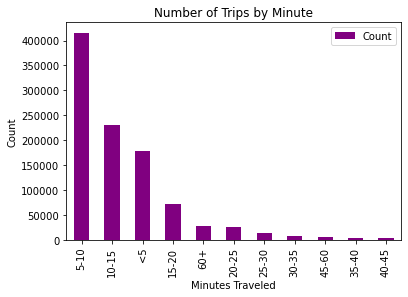

In [6]:
##Histogram for Minute Breakouts
min_trip = pd.read_csv('min_trip.csv')
min_trip.columns = ['Duration Break', 'Count']
trip = min_trip.style.set_caption("Trips by Duration")
display(trip)
min_trip.plot(kind='bar', x = 'Duration Break', y = 'Count', xlabel = "Minutes Traveled", ylabel = "Count", title="Number of Trips by Minute", color="purple")

#### Deals by Minutes Traveled 
Currently Members get unlimited 45 minute classic rides.
But, the above graph shows that by far the most common trips are 15 minutes or less.
Due to this, we decided to break down the data further by Subscriber or not to decide if the recommendation should be with respect to that metric as well.

In [7]:
##Customers vs Subscribers
! bq query --use_legacy_sql=FALSE --format=csv 'select subscriber_type,COUNT(1)  from bigquery-public-data.san_francisco.bikeshare_trips GROUP BY subscriber_type'

Waiting on bqjob_r74b03dc25d639693_000001779d8b3e97_1 ... (0s) Current status: DONE   
subscriber_type,f0_
Customer,136809
Subscriber,846839


There are more than 6 times as many trips by Subscribers than Non-Subscribers.

In [8]:
##Query to csv Minute Breakouts by Subscribers and Others
! bq query --use_legacy_sql=FALSE --format=csv ' SELECT dur_min_str, COUNT(*) AS `le_count` FROM (SELECT duration_sec, subscriber_type, CASE WHEN duration_sec < 300 THEN "<5" WHEN duration_sec >= 300 and duration_sec < 600 THEN "5-10" WHEN duration_sec >= 600 and duration_sec < 900 THEN "10-15" WHEN duration_sec >= 900 and duration_sec < 1200 THEN "15-20" WHEN duration_sec >= 1200 and duration_sec < 1500 THEN "20-25" WHEN duration_sec >= 1500 and duration_sec < 1800 THEN "25-30" WHEN duration_sec >= 1800 and duration_sec < 2100 THEN "30-35" WHEN duration_sec >= 2100 and duration_sec < 2400 THEN "35-40" WHEN duration_sec >= 2400 and duration_sec < 2700 THEN "40-45" WHEN duration_sec >= 2700 and duration_sec < 3600 THEN "45-60" WHEN duration_sec >= 3600 THEN "60+" END AS dur_min_str FROM bigquery-public-data.san_francisco.bikeshare_trips) WHERE subscriber_type = "Subscriber" GROUP BY dur_min_str ORDER BY le_count DESC' > sub_min_trip.csv
! bq query --use_legacy_sql=FALSE --format=csv ' SELECT dur_min_str, COUNT(*) AS `le_count` FROM (SELECT duration_sec, subscriber_type, CASE WHEN duration_sec < 300 THEN "<5" WHEN duration_sec >= 300 and duration_sec < 600 THEN "5-10" WHEN duration_sec >= 600 and duration_sec < 900 THEN "10-15" WHEN duration_sec >= 900 and duration_sec < 1200 THEN "15-20" WHEN duration_sec >= 1200 and duration_sec < 1500 THEN "20-25" WHEN duration_sec >= 1500 and duration_sec < 1800 THEN "25-30" WHEN duration_sec >= 1800 and duration_sec < 2100 THEN "30-35" WHEN duration_sec >= 2100 and duration_sec < 2400 THEN "35-40" WHEN duration_sec >= 2400 and duration_sec < 2700 THEN "40-45" WHEN duration_sec >= 2700 and duration_sec < 3600 THEN "45-60" WHEN duration_sec >= 3600 THEN "60+" END AS dur_min_str FROM bigquery-public-data.san_francisco.bikeshare_trips) WHERE subscriber_type = "Customer" GROUP BY dur_min_str ORDER BY le_count DESC' > cus_min_trip.csv

Waiting on bqjob_r116171312a2b8652_000001779d8b461c_1 ... (0s) Current status: DONE   
Waiting on bqjob_r5b63a0031047292a_000001779d8b4c5e_1 ... (0s) Current status: DONE   


,Duration Break,Count
0,60+,25826
1,10-15,24967
2,5-10,23263
3,15-20,18713
4,20-25,13460
5,25-30,9140
6,45-60,5685
7,<5,5234
8,30-35,5031
9,35-40,3153


,Duration Break,Count
0,5-10,392673
1,10-15,206132
2,<5,173458
3,15-20,53485
4,20-25,11582
5,25-30,4173
6,60+,2270
7,30-35,1389
8,35-40,659
9,45-60,656


<AxesSubplot:title={'center':'Customer - Number of Trips by Minute'}, xlabel='Minutes Traveled', ylabel='Count'>

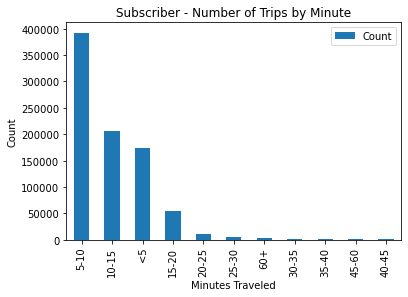

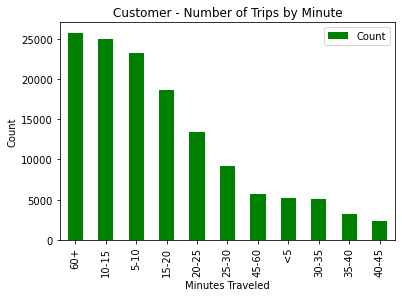

In [9]:
##Histogram for Minute Breakouts
from IPython.display import display

sub_min_trip = pd.read_csv('sub_min_trip.csv')
cus_min_trip = pd.read_csv('cus_min_trip.csv')
sub_min_trip.columns = ['Duration Break', 'Count']
cus_min_trip.columns = ['Duration Break', 'Count']
sub = sub_min_trip.style.set_caption("Subscriber Trips by Duration")
cus = cus_min_trip.style.set_caption("Non-Subscriber Trips by Duration")
display(cus)
display(sub)
sub_min_trip.plot(kind='bar', x = 'Duration Break', y = 'Count', xlabel = "Minutes Traveled", ylabel = "Count", title="Subscriber - Number of Trips by Minute")
cus_min_trip.plot(kind='bar', x = 'Duration Break', y = 'Count', xlabel = "Minutes Traveled", ylabel = "Count", title="Customer - Number of Trips by Minute", color='g')


### Deals by Minute with respect to Subscriber Status
1.) Subscribers are not using trips over 20 minutes with any where near the frequency as under 20 minutes. This could be a great way to not inconvenience the subscribers but also to gain a small amount of profit. 

#### *RECOMMENDATION:* We ask to consider changing the offer from free rides under 45 minutes to free rides under 25 minutes.

2.) Non-subscribers are not nearly as incentivized to make frequent trips with our company. We suggest introducing a deal for non-subscribers. Non-subscribers are more likely than our subscribers to use the bike for 60+ minutes. This is great. We want to focus on increasing the short frequency trips through incentive in the less than 20 minute category. Trips that are under 5 minutes are quite few. But there is room for growth under 20.

#### *RECOMMENDATION:* We ask to consider adding a first 5 minutes free with proper docking for non-subscribers.

## Analysis 2 - Top stations by commuters

- After initial querries about top trips taken, it was decided that we would take it a step further and understand the breakdown of subscribers vs. regular customers.
- This would allow us to understand who are commuters better, assuming commuters are subscribers

In [10]:
#Querry to csv stations, subscriber count, customer count, total trips, and subscruber ratio
! bq query --use_legacy_sql=false --format=csv 'SELECT subscribers.start_station_name as station, subscribers.subscriber_count, customers.customer_count, subscribers.subscriber_count + customers.customer_count as total_rides, subscribers.subscriber_count / (subscribers.subscriber_count + customers.customer_count) as subscriber_ratio FROM (SELECT start_station_name, COUNT(subscriber_type) as subscriber_count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE ((TIME(start_date) >= "06:00:00" AND TIME(start_date) <= "09:00:00") OR (TIME(start_date) >= "15:00:00" AND TIME(start_date) >= "19:00:00")) AND CAST(FORMAT_DATE("%w", DATE(start_date)) AS int64) > 0 AND CAST(FORMAT_DATE("%w", DATE(start_date)) AS int64) < 6 AND subscriber_type = "Subscriber" GROUP BY start_station_name) as subscribers, (SELECT start_station_name, COUNT(subscriber_type) as customer_count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE ((TIME(start_date) >= "06:00:00" AND TIME(start_date) <= "09:00:00") OR (TIME(start_date) >= "15:00:00" AND TIME(start_date) >= "19:00:00")) AND CAST(FORMAT_DATE("%w", DATE(start_date)) AS int64) > 0 AND CAST(FORMAT_DATE("%w", DATE(start_date)) AS int64) < 6 AND subscriber_type = "Customer" GROUP BY start_station_name) as customers WHERE subscribers.start_station_name = customers.start_station_name ORDER BY total_rides DESC LIMIT 30' > stations_by_subs.csv

Waiting on bqjob_r73dcfa3279451f72_000001779d8b558a_1 ... (0s) Current status: DONE   


In [11]:
subs = pd.read_csv('stations_by_subs.csv')
subs

,station,subscriber_count,customer_count,total_rides,subscriber_ratio
0,San Francisco Caltrain (Townsend at 4th),38448,1083,39531,0.972604
1,San Francisco Caltrain 2 (330 Townsend),26080,547,26627,0.979457
2,Harry Bridges Plaza (Ferry Building),18848,1302,20150,0.935385
3,Temporary Transbay Terminal (Howard at Beale),17696,294,17990,0.983658
4,Steuart at Market,12010,545,12555,0.956591
5,2nd at Townsend,9565,688,10253,0.932898
6,Grant Avenue at Columbus Avenue,9284,518,9802,0.947154
7,Townsend at 7th,8908,233,9141,0.974510
8,Market at 10th,8494,413,8907,0.953632
9,Embarcadero at Sansome,7455,1310,8765,0.850542


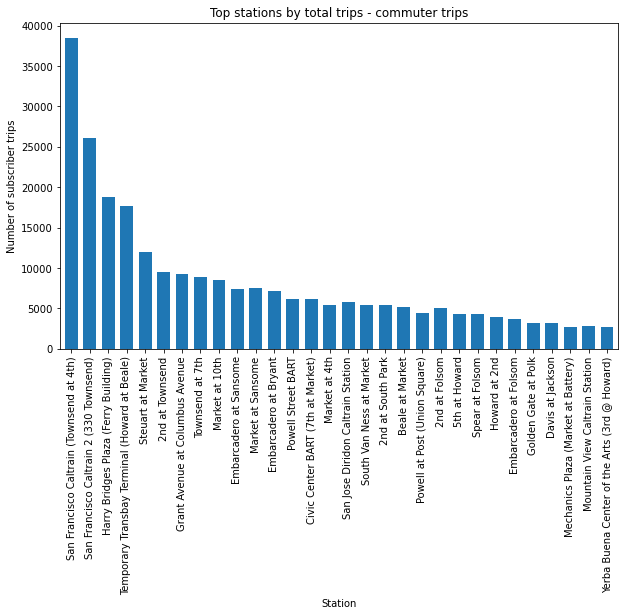

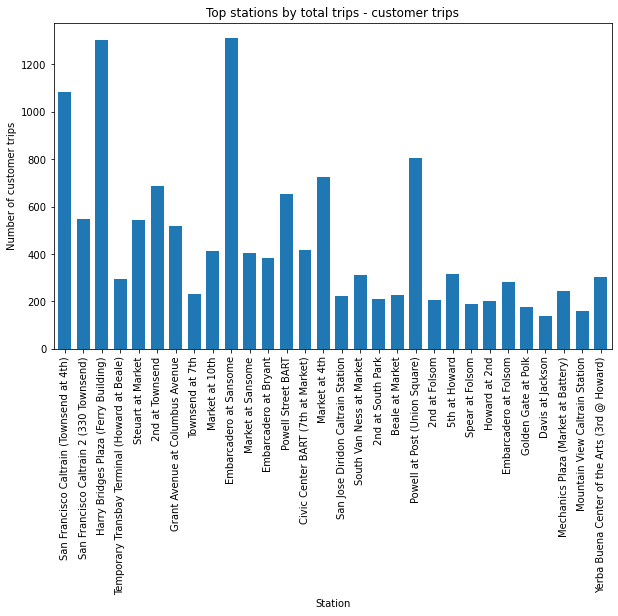

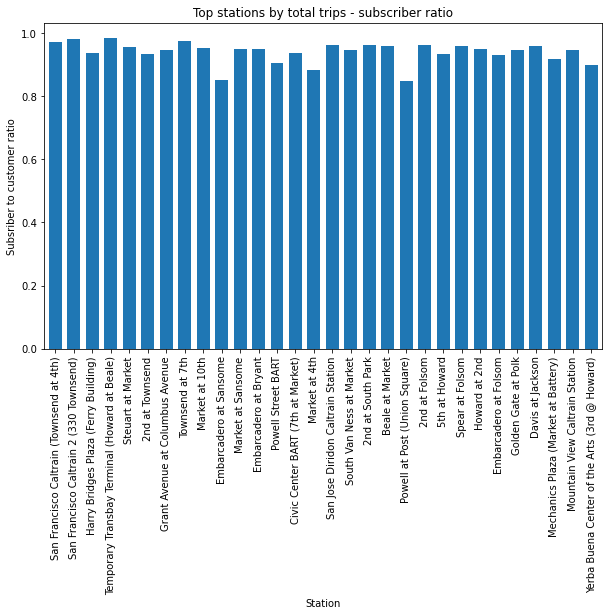

In [13]:
fig, ax = plt.subplots()
bar = subs['subscriber_count'].plot.bar(figsize=(10,6), width=.7)
ax.set_xticklabels(subs['station'])
plt.title("Top stations by total trips - commuter trips")
plt.xlabel('Station')
plt.ylabel('Number of subscriber trips')
plt.show()

fig, ax = plt.subplots()
bar = subs['customer_count'].plot.bar(figsize=(10,6), width=.7)
ax.set_xticklabels(subs['station'])
plt.title("Top stations by total trips - customer trips")
plt.xlabel('Station')
plt.ylabel('Number of customer trips')
plt.show()

fig, ax = plt.subplots()
bar = subs['subscriber_ratio'].plot.bar(figsize=(10,6), width=.7)
ax.set_xticklabels(subs['station'])
plt.title("Top stations by total trips - subscriber ratio")
plt.xlabel('Station')
plt.ylabel('Subsriber to customer ratio')
plt.show()

### Top stations with respect to membership status
- From 6am to 9am and 3pm to 7pm, stations tend to have mostly subscribers (assumed to be commuters) traveling from them
- San Francisco Caltrain (Townsend at 4th) and San Francisco Caltrain 2 (330 Townsend) have by far the most trips started during these hours with both having around 97% subscribers taking these trips

#### RECOMMENDATIONS
- To increase customer ridership during these hours, we suggest introducing a deal to customers to try and incentivise them to take trips during these hours to increase customer revenue. This is if capacity and traffic is not an issue
- If availability is an issue, we suggest offering deals to stations nearby to increase throughput

In [2]:
%%bigquery top_20_stations

SELECT
start_station_name,
end_station_name,
COUNT(trip_id) as num_trip
FROM bigquery-public-data.san_francisco.bikeshare_trips
WHERE EXTRACT(DAYOFWEEK from start_date) <> 6
AND EXTRACT(DAYOFWEEK from start_date) <> 7
AND start_station_id <> end_station_id
AND EXTRACT(DAYOFYEAR from start_date) = EXTRACT(DAYOFYEAR from end_date)
AND (
(EXTRACT(HOUR from start_date) between 6 and 9
AND EXTRACT(HOUR from end_date) between 6 and 9)
OR
(EXTRACT(HOUR from start_date) between 16 and 19
AND EXTRACT(HOUR from end_date) between 16 and 19)
)
GROUP BY start_station_name, end_station_name
ORDER BY num_trip DESC
limit 20
8:09
pvt = top_20_stations.pivot(index = ‘start_station_name’,
                     columns = ‘end_station_name’,
                     values = ‘num_trip’).fillna(0)
8:09
sns.heatmap(pvt,linewidths=0.5,cmap=‘YlGnBu’)

UsageError: Cell magic `%%bigquery` not found.
